In [31]:
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
#import tensorflow_datasets as tfds
import tensorflow.keras.optimizers
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cartopy.crs as ccrs
import cartopy.feature as cf
import pickle 
from datetime import date
import xarray as xr


In [32]:
# Define domain and time period
start_lat = 12 # 5 
end_lat = 17 #10
start_lon = -17 #-10
end_lon = -12 #0
start_year = '2010'
start_month = '06'
end_year = '2010'
end_month = '9'
start_day = '01'
end_day = '30'


# get native MSG grid (core)
coords_filename= './nxny1640_580_nxnyds164580_blobdx0.04491576_area4_n23_20_32.nc'#[0]  # this is /prj/Africa_cloud/geoloc/*.npz on the Linux system
msg_file = xr.open_dataset(coords_filename).squeeze() # pick any convective core file from ch9_wavelet. 
mlon = msg_file['lons_mid'].values
mlat = msg_file['lats_mid'].values
# find core indices using one file
lat_ind = np.where((mlat[:,1]>=start_lat) & (mlat[:,1]<=end_lat))[0]
lon_ind = np.where((mlon[1,:]>=start_lon) & (mlon[1,:]<=end_lon))[0]
lat = mlat[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
lon = mlon[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
#lon = lon_fl[(lon_fl>= start_lon) & (lon_fl<=end_lon)]
#X, Y = np.meshgrid(lon,lat)


In [2]:
# open a file, where you stored the pickled data
file = open('pkl_files/WA_subdomain_cores_2hr_back.pkl', 'rb')
data = pickle.load(file)
cores_t_0= data[0]
tir_t_0= data[1]
cores_t_plus_xhr= data[2]

In [3]:
print(cores_t_0.shape)
print(tir_t_0.shape)
print(cores_t_plus_xhr.shape)

(11711, 128, 128)
(11711, 128, 128)
(11711, 128, 128)


In [4]:
# training data
cores_t_0_minus_1 = cores_t_0[0:-1]
tir_t_0_minus_1 = tir_t_0[0:-1]
cores_t_0 = cores_t_0[1:]
tir_t_0 = tir_t_0[1:]
cores_t_plus_xhr= cores_t_plus_xhr[1:]


In [5]:
print(cores_t_0.shape)
print(tir_t_0.shape)
print(cores_t_plus_xhr.shape)
print(cores_t_0_minus_1.shape)



(11710, 128, 128)
(11710, 128, 128)
(11710, 128, 128)
(11710, 128, 128)


In [6]:
# Define input shape
#num_frames= 24  # 6 hours
image_height= len(cores_t_plus_xhr[1,:,1]) #lat
image_width= len(cores_t_plus_xhr[1,1,:]) #lon
num_channels= 2 #  core at t0-, core at t0-1,  



In [7]:
#batch_size= int(len(cores_t_0[:,0,0])/num_frames)  # days 720 - 96 one day
#x_train= cores_t_0[i*num_frames:(i+1)*num_frames,:,:]
total_samples= int(cores_t_0.shape[0])
val_samples= int(total_samples*0.1)
left_samples = int(total_samples-val_samples)

x_train= np.zeros((left_samples,image_height,image_width, num_channels))
y_train= np.zeros((left_samples,image_height,image_width, 1))
x_val= np.zeros((val_samples,image_height,image_width, num_channels))
y_val= np.zeros((val_samples,image_height,image_width, 1))
                     
for i in range(0,left_samples,1):  
    x_train[i,:,:,0]= cores_t_0[i,:,:]
    x_train[i,:,:,1]= cores_t_0_minus_1[i,:,:]
    y_train[i,:,:,0]= cores_t_plus_xhr[i,:,:]
        
for i in range(left_samples,total_samples,1):  
    x_val[i-left_samples,:,:,0]= cores_t_0[i,:,:]
    x_val[i-left_samples,:,:,1]= cores_t_0_minus_1[i,:,:]
    y_val[i-left_samples,:,:,0]= cores_t_plus_xhr[i,:,:]
          
# normalize input data        
#x_train = x_train/np.max(x_train)

In [8]:
print(x_train.shape)
print(x_val.shape)
print(total_samples)
print(val_samples)

(10539, 128, 128, 2)
(1171, 128, 128, 2)
11710
1171


In [22]:
## a clean way of plotting - use matplotlib functions directly:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
def draw_map(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)

In [23]:
def plot_maps(ax, lon, lat, data, title,levels_custom):
    m=ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), levels=levels_custom,cmap='jet')  # this is the actual plot
    ax.coastlines()   ## adds coastlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    #cbar = plt.colorbar(m)  # adds colorbar
    #cbar.set_label('core')

In [52]:
def plot_maps_colorbar(ax, lon, lat, data, title,levels_custom):
    m=ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), levels=levels_custom,cmap='jet')  # this is the actual plot
    ax.coastlines()   ## adds coastlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(m)  # adds colorbar
    cbar.set_label('Probability of Core')

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D)
from tensorflow.keras import layers
#import tensorflow_addons as tfa # this is only for GroupNormalization which can be replaced by keras BatchNorm

def conv_layer(x_in, filters, gn_num, strides = 1, shape = (image_height,image_width), name=None):
    x = Conv2D(filters, 5, strides=strides, padding='same')(x_in)
    x = Activation('relu', name = name)(x)
   ## x = layers.BatchNormalization()(x)
    #x = tfa.layers.GroupNormalization(groups=gn_num, axis=3)(x) # could replace this with BatchNorm
    return x


In [10]:

def unet_basic(input_shape=(image_height, image_width, num_channels), chan_num=num_channels):

    inputs = Input(shape=input_shape)    # 128 x 128 x 2
    down2 = conv_layer(inputs, 4, 8)     # 128 x 128 x 4
  #  down2 = conv_layer(down2, 8, 8)    # 128 x 128 x 8
    down2_pool = MaxPooling2D((2, 2), strides=None)(down2)   # 64 x 64 x 4

    down3 = conv_layer(down2_pool, 8, 4) # 64 x 64 x 8
 #   down3 = conv_layer(down3, 32, 4) # 64 x 64 x 32
    down3_pool = MaxPooling2D((2, 2), strides=None)(down3) # 32 x 32 x 8

    center = conv_layer(down3_pool, 16, 4) # 32 x 32 x 16
    center = conv_layer(center, 8, 4) # 32 x 32 x 8
    # center

    up3 = UpSampling2D((2, 2))(center) # 64 x 64 x 8
    # note the skip-connections that join same-dimension
    # stages of the down branch and up branch of the U:
    up3 = concatenate([down3, up3], axis=3) # 64 x 64 x 8
 #   up3 = conv_layer(up3, 32, 16) # 64 x 64 x 32
    up3 = conv_layer(up3, 4, 16) # 64 x 64 x 4

    up2 = UpSampling2D((2, 2))(up3) # 128 x 128 x 4
    up2 = concatenate([down2, up2], axis=3) # 128 x 128 x 4
    up2 = conv_layer(up2, 4, 8) # 128 x 128 x 4
  #  up2 = conv_layer(up2, 8, 8) # 128 x 128 x 8
    #up2 = conv_layer(up2, 32, 8)


    # predict
    output = Conv2D(1, (1, 1))(up2)
        # could add an activation here to get output in desired form, e.g. for a probability map:
    output = layers.Activation('sigmoid', dtype='float32', name='prob_pred')(output)

    # create model object
    unet = Model(inputs=inputs, outputs=output, name = 'prob_map_unet')
        # can also return intermediate feature maps along with the final probability map if desired, e.g.:
        ##unet = Model(inputs=inputs, outputs=[output, up0a], name = 'prob_map_unet')
    return unet

In [11]:
unet_model = unet_basic(input_shape=(image_height, image_width, num_channels), chan_num=num_channels)


In [12]:
unet_model.summary()

Model: "prob_map_unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 4)  204         ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 128, 128, 4)  0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 4)    0           ['activation[0][0]'] 

In [13]:
unet_model.compile(optimizer=tensorflow.keras.optimizers.Adam(),
                  loss="binary_crossentropy",
                  metrics="accuracy")

In [14]:
# Define modifiable training hyperparameters.
epochs = 5 # 20
batch_size = 4 #50# batch_size#24
#TRAIN_LENGTH = info.splits["train"].num_examples
#STEPS_PER_EPOCH = TRAIN_LENGTH // batch_size
#VAL_SUBSPLITS = 5
#TEST_LENTH = info.splits["test"].num_examples
#VALIDATION_STEPS = TEST_LENTH // batch_size // VAL_SUBSPLITS

# Fit the model to the training data.
model_history = unet_model.fit(x_train,
                               y_train,
                               batch_size=batch_size,
                               epochs=epochs,
                               validation_data=(x_val, y_val),
)

#    callbacks=[early_stopping, reduce_lr],


Epoch 1/5
2635/2635 [==============================] - 127s 47ms/step - loss: 0.0196 - accuracy: 0.9948 - val_loss: 0.0222 - val_accuracy: 0.9920
Epoch 2/5
2635/2635 [==============================] - 117s 44ms/step - loss: 0.0131 - accuracy: 0.9954 - val_loss: 0.0222 - val_accuracy: 0.9921
Epoch 3/5
2635/2635 [==============================] - 118s 45ms/step - loss: 0.0128 - accuracy: 0.9954 - val_loss: 0.0222 - val_accuracy: 0.9920
Epoch 4/5
2635/2635 [==============================] - 118s 45ms/step - loss: 0.0127 - accuracy: 0.9955 - val_loss: 0.0217 - val_accuracy: 0.9921
Epoch 5/5
2635/2635 [==============================] - 118s 45ms/step - loss: 0.0126 - accuracy: 0.9955 - val_loss: 0.0212 - val_accuracy: 0.9923


In [54]:
#for b in range(0,51,1):
batch_number = 5 # 0,1
frames = x_val[batch_number,:,:,:] # 
original_frame = y_val[batch_number,:,:,:] # 
print(frames.shape)


# Extract the model's prediction and post-process it.
predicted_frame = unet_model.predict(np.expand_dims(frames, axis=0))

(128, 128, 2)
1/1 [==============================] - 0s 16ms/step


In [55]:
print(predicted_frame.shape)
print(np.unique(predicted_frame))

(1, 128, 128, 1)
[7.749516e-05 7.749664e-05 7.752946e-05 ... 9.869451e-01 9.874081e-01
 9.888493e-01]


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


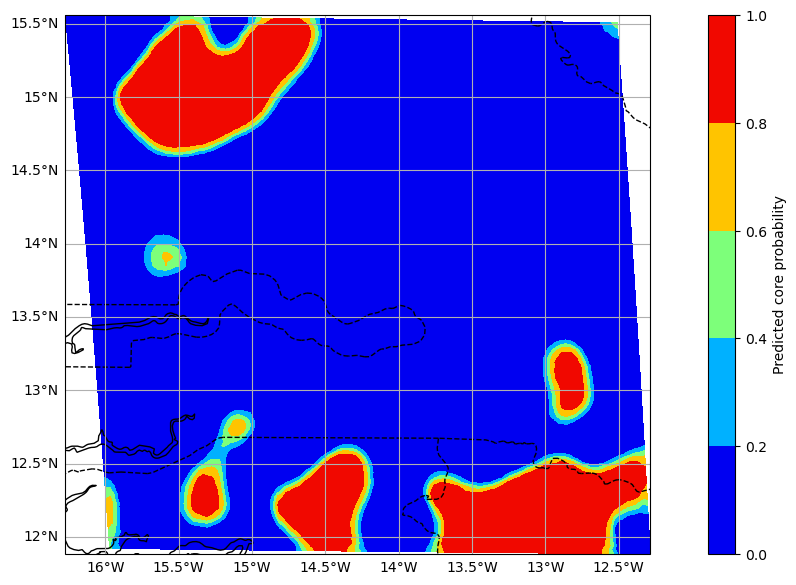

In [56]:
t0= 0#1   #*4 # # 15 min  later (4 frames at 15 min)
a= 45
b= 48

f=plt.figure(figsize=(15,7)) 
ax = f.add_subplot(111, projection=ccrs.PlateCarree()) 
draw_map(ax, np.squeeze(predicted_frame[0,:,:,0]), lon[:-a,b:], lat[:-a,b:],levels=[0, 0.2, 0.4, 0.6, 0.8,1], cbar_label='Predicted core probability', cmap='jet')

#np.

In [59]:
# cores t to
#f=plt.figure(figsize=(15,7)) 
#ax = f.add_subplot(111, projection=ccrs.PlateCarree()) 
#draw_map(ax, np.squeeze(frames[:,:,1]), lon[:-a,b:], lat[:-a,b:],levels=[0, 0.2, 0.4, 0.6, 0.8,1], cbar_label='Core at to', cmap='jet')


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility

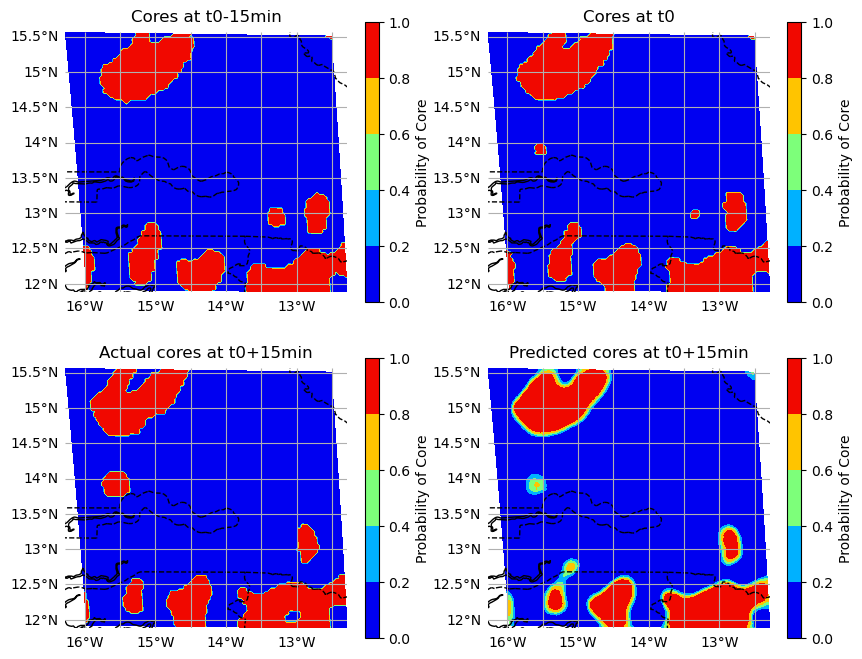

In [58]:
data = np.zeros((4,image_height,image_width))
data[0] = np.squeeze(frames[:,:,1])
data[1] = np.squeeze(frames[:,:,0])
data[2] = np.squeeze(original_frame[:,:,0])
data[3] = np.squeeze(predicted_frame[0,:,:,0])
titles = ['Cores at t0-15min','Cores at t0', 'Actual cores at t0+15min', 'Predicted cores at t0+15min']
levels_custom=[[0, 0.2, 0.4, 0.6, 0.8,1],[0, 0.2, 0.4, 0.6, 0.8,1],np.arange(0,1.05,0.2)]

fig, axes = plt.subplots(2, 2, figsize=(10, 8),
                         subplot_kw={'projection':ccrs.PlateCarree()})

for idx, ax in enumerate(axes[0]):
    plot_maps_colorbar(ax, lon[:-a,b:], lat[:-a,b:], data[idx],  title=None ,levels_custom= levels_custom[0])
    ax.set_title(titles[idx])
    ax.axis("off")

for idx, ax in enumerate(axes[1]):
    plot_maps_colorbar(ax, lon[:-a,b:], lat[:-a,b:], data[idx+2],  title=None ,levels_custom= levels_custom[0])
    ax.set_title(titles[idx+2])
    ax.axis("off")

# Print information and display the figure.
#print('Predicting core at 1hr')
plt.show()

(128, 128, 2)
1/1 [==============================] - 0s 15ms/step


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility

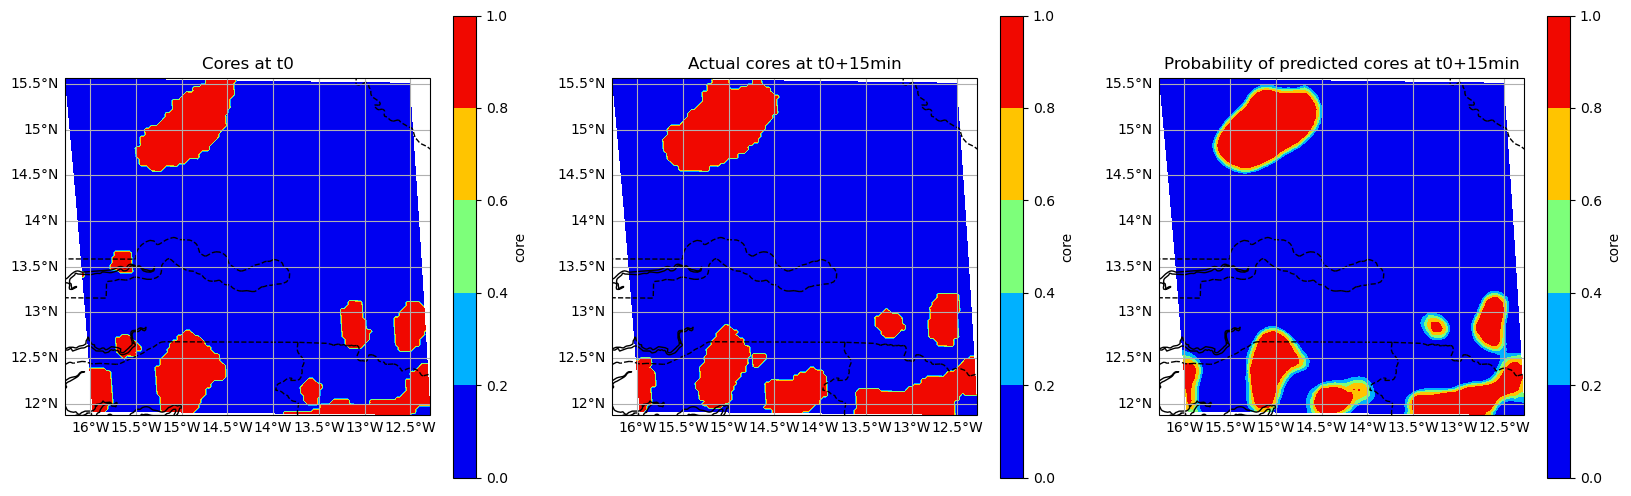

In [48]:
#for b in range(0,51,1):
batch_number = 2 # 0,1
frames = x_val[batch_number,:,:,:] # 
original_frame = y_val[batch_number,:,:,:] # 
print(frames.shape)


# Extract the model's prediction and post-process it.
predicted_frame = unet_model.predict(np.expand_dims(frames, axis=0))

# plot data
data = np.zeros((3,image_height,image_width))
#data[0] = np.squeeze(frames[day-4*t0,:,:,0])
data[0] = np.squeeze(frames[:,:,1])
data[1] = np.squeeze(original_frame[:,:,0])
data[2] = np.squeeze(predicted_frame[0,:,:,0])
#titles = ['Cores at t0-1hr', 'Cores at t0', 'Probability of cores at t0+1hr']
titles = ['Cores at t0', 'Actual cores at t0+15min', 'Probability of predicted cores at t0+15min']
levels_custom=[[0, 0.2, 0.4, 0.6, 0.8,1],[0, 0.2, 0.4, 0.6, 0.8,1],np.arange(0,1.05,0.2)]

fig, axes = plt.subplots(1, 3, figsize=(20, 6),
                         subplot_kw={'projection':ccrs.PlateCarree()})

i=0
for ax in axes:
    m= ax.contourf(lon[:-a,b:], lat[:-a,b:], data[i], transform=ccrs.PlateCarree(), levels=levels_custom[i],cmap='jet')  # this is the actual plot
# ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(titles[i])
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(m)  # adds colorbar
    cbar.set_label('core')
    i=i+1
 
#plt.show()